In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt


In [6]:
!pip install torch==2.1.0 triton==2.1.0 --force-reinstall


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 MB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 54.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 46.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 55.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.8/209.8 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [3]:
model = nn.Linear(10, 2)
optimizer = optim.Adam(model.parameters(), lr=0.001)
print("Success!")

Success!


In [4]:
# Generate synthetic data
def generate_data(n_samples=1000, seq_len=20):
    x = np.sin(np.linspace(0, 3 * np.pi, seq_len))  # basic sine wave
    data = np.array([x + np.random.normal(0, 0.1, size=x.shape) for _ in range(n_samples)])
    return data

In [5]:
# Add noise
def add_noise(data, noise_factor=0.5):
    noisy = data + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=data.shape)
    return np.clip(noisy, -1., 1.)

In [6]:
# Autoencoder Model
class Autoencoder(nn.Module):
    def __init__(self, seq_len):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(seq_len, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, seq_len),
            nn.Tanh()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [7]:
# Transformer Model
class TransformerDenoiser(nn.Module):
    def __init__(self, seq_len, d_model=64, nhead=4, num_layers=2):
        super(TransformerDenoiser, self).__init__()
        self.embedding = nn.Linear(1, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.decoder = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.embedding(x)
        x = self.transformer_encoder(x)
        x = self.decoder(x)
        return x

In [8]:
# Training function
def train(model, criterion, optimizer, x_train, y_train, epochs=50):
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(x_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

In [9]:
# Main
seq_len = 20
data = generate_data(n_samples=1000, seq_len=seq_len)
noisy_data = add_noise(data)
# Train Autoencoder
x_train = torch.tensor(noisy_data, dtype=torch.float32)
y_train = torch.tensor(data, dtype=torch.float32)

autoencoder = Autoencoder(seq_len)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

print("Training Autoencoder...")
train(autoencoder, criterion, optimizer, x_train, y_train)





Training Autoencoder...
Epoch [10/50], Loss: 0.4404
Epoch [20/50], Loss: 0.3900
Epoch [30/50], Loss: 0.3043
Epoch [40/50], Loss: 0.1756
Epoch [50/50], Loss: 0.0680


In [10]:
# Train Transformer
x_train_transformer = torch.tensor(noisy_data[:, :, None], dtype=torch.float32)  # (batch, seq_len, 1)
y_train_transformer = torch.tensor(data[:, :, None], dtype=torch.float32)

transformer = TransformerDenoiser(seq_len)
criterion = nn.MSELoss()
optimizer = optim.Adam(transformer.parameters(), lr=0.001)

print("Training Transformer...")
train(transformer, criterion, optimizer, x_train_transformer, y_train_transformer)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Training Transformer...
Epoch [10/50], Loss: 0.3037
Epoch [20/50], Loss: 0.0576
Epoch [30/50], Loss: 0.0346
Epoch [40/50], Loss: 0.0258
Epoch [50/50], Loss: 0.0230


In [11]:
# Test
test_data = generate_data(n_samples=5, seq_len=seq_len)
test_noisy = add_noise(test_data)

In [12]:

# Assuming you want to use the default device, either CPU or the available GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
autoencoder = Autoencoder(seq_len).to(device)


In [19]:
# Autoencoder prediction
autoencoder.eval()
test_input = torch.tensor(test_noisy, dtype=torch.float32)
denoised_output_ae = autoencoder(test_input).detach().cpu().numpy()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)



Using device: cpu


In [20]:
# Transformer prediction
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Ensure the model is on the right device
transformer = TransformerDenoiser(seq_len).to(device)

# Prepare test data and ensure it's also on the correct device
test_input_trans = torch.tensor(test_noisy[:, :, None], dtype=torch.float32).to(device)

# Evaluate the model (without gradients)
transformer.eval()
with torch.no_grad():
    denoised_output_trans = transformer(test_input_trans).squeeze(-1).detach().cpu()



In [21]:
transformer.eval()
test_input_trans = torch.tensor(test_noisy[:, :, None], dtype=torch.float32).to(device)
with torch.no_grad():
    denoised_output_trans = transformer(test_input_trans).squeeze(-1).detach().cpu().numpy()


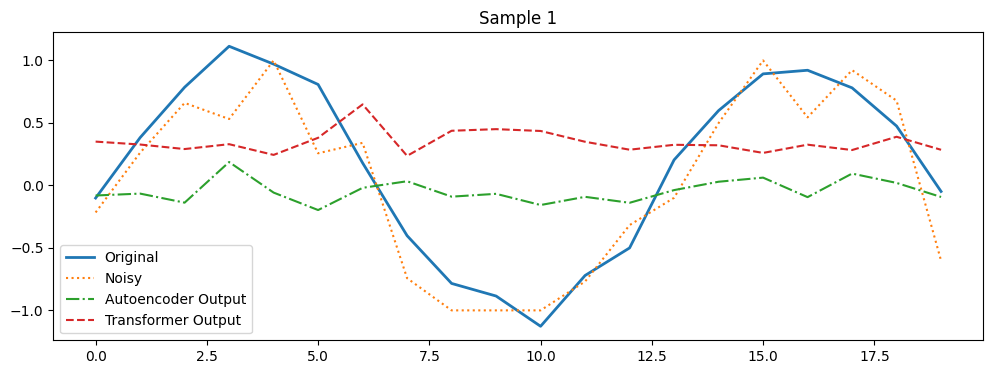

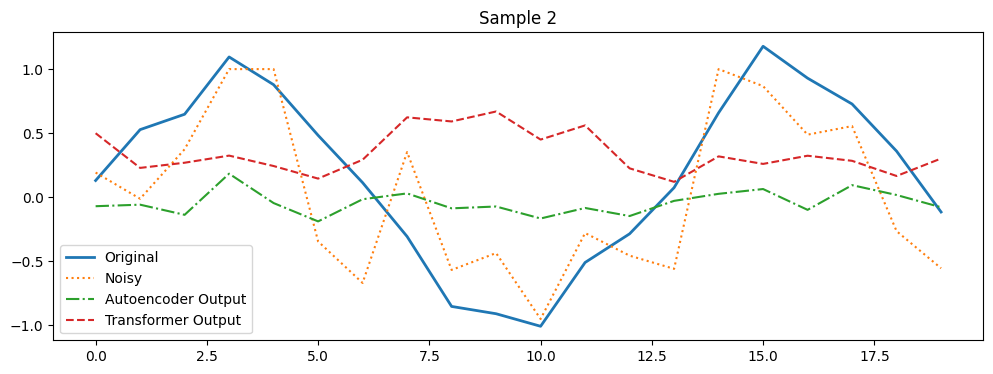

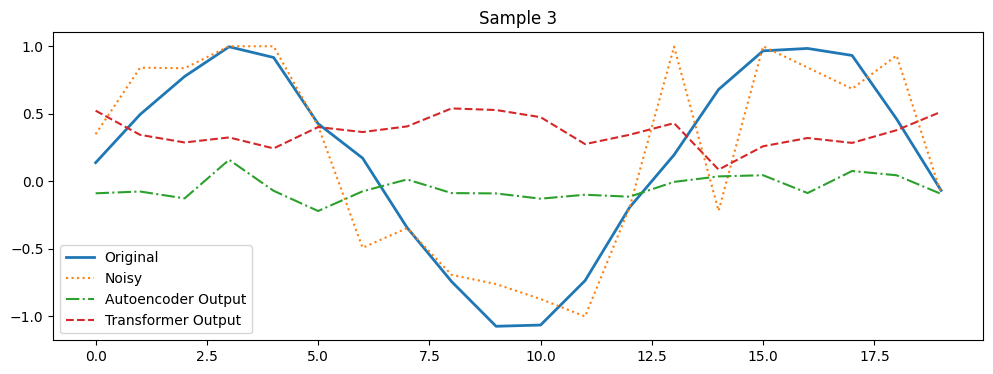

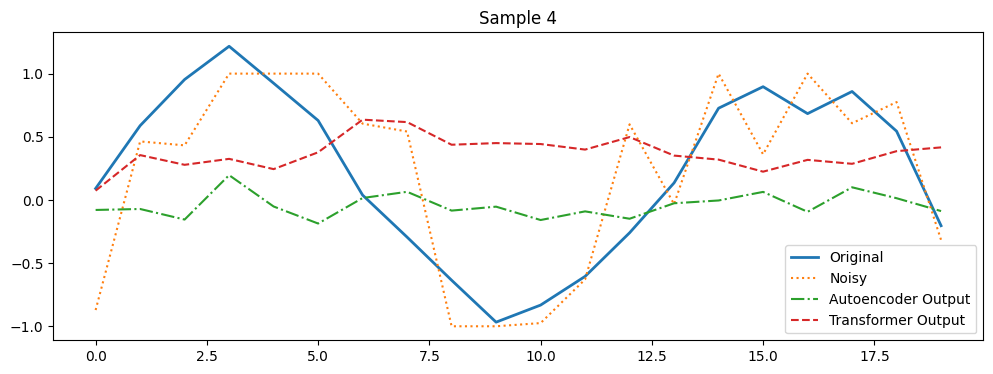

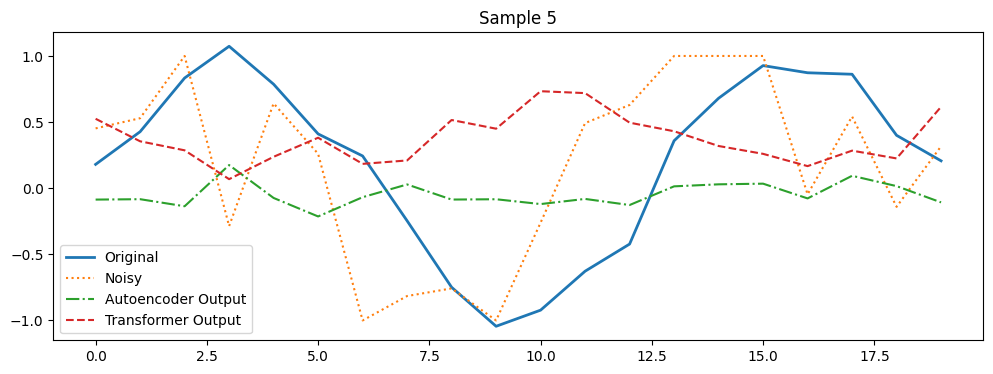

In [22]:
# Plotting
for i in range(5):
    plt.figure(figsize=(12, 4))
    plt.plot(test_data[i], label='Original', linewidth=2)
    plt.plot(test_noisy[i], label='Noisy', linestyle='dotted')
    plt.plot(denoised_output_ae[i], label='Autoencoder Output', linestyle='dashdot')
    plt.plot(denoised_output_trans[i], label='Transformer Output', linestyle='dashed')
    plt.legend()
    plt.title(f"Sample {i+1}")
    plt.show()